In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [2]:
import os, shutil
import random

def create_split(source_dir, dest_dir, split_ratio=0.8):
    classes = ['NORMAL', 'PNEUMONIA']
    for cls in classes:
        os.makedirs(os.path.join(dest_dir, 'train', cls), exist_ok=True)
        os.makedirs(os.path.join(dest_dir, 'val', cls), exist_ok=True)
        files = os.listdir(os.path.join(source_dir, cls))
        random.shuffle(files)
        split = int(len(files) * split_ratio)
        for f in files[:split]:
            shutil.copy(os.path.join(source_dir, cls, f), os.path.join(dest_dir, 'train', cls))
        for f in files[split:]:
            shutil.copy(os.path.join(source_dir, cls, f), os.path.join(dest_dir, 'val', cls))

create_split('chest_xray/train', 'custom_data', split_ratio=0.8)


In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (150, 150)
batch_size = 32


train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='constant',
    brightness_range=[0.9, 1.1]
).flow_from_directory('custom_data/train', target_size=img_size, batch_size=32, class_mode='binary')

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory('custom_data/val', target_size=img_size, batch_size=batch_size, class_mode='binary')

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory('chest_xray/test', target_size=img_size, batch_size=batch_size, class_mode='binary')


Found 4172 images belonging to 2 classes.
Found 1044 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [44]:
import collections
print(collections.Counter(train_gen.classes))


Counter({np.int32(1): 3100, np.int32(0): 1072})


In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, LeakyReLU, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2

def build_model(activation='relu'):
    model = Sequential()


    model.add(Input(shape=(150,150,3)))
    model.add(Conv2D(16, (3,3), padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU() if activation == 'leaky_relu' else Activation(activation))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.3))


    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU() if activation == 'leaky_relu' else Activation(activation))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.4))


    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU() if activation == 'leaky_relu' else Activation(activation))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.5))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, kernel_regularizer=l2(0.001)))
    model.add(LeakyReLU() if activation == 'leaky_relu' else Activation(activation))
    model.add(Dropout(0.6))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(name='auc')])

    return model


In [50]:
model = build_model(activation='relu')

from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)


history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight={0: class_weights[0], 1: class_weights[1]}

)


Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.6544 - auc: 0.6781 - loss: 0.7626

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 81s 555ms/step - accuracy: 0.6550 - auc: 0.6791 - loss: 0.7618 - val_accuracy: 0.7423 - val_auc: 0.5989 - val_loss: 0.7883 - learning_rate: 5.0000e-04
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 63s 481ms/step - accuracy: 0.8314 - auc: 0.9056 - loss: 0.5118 - val_accuracy: 0.7423 - val_auc: 0.4456 - val_loss: 1.5842 - learning_rate: 5.0000e-04
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 63s 481ms/step - accuracy: 0.8514 - auc: 0.9212 - loss: 0.4636 - val_accuracy: 0.7423 - val_auc: 0.9108 - val_loss: 0.8602 - learning_rate: 5.0000e-04
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 63s 480ms/step - accuracy: 0.8620 - auc: 0.9314 - loss: 0.4155 - val_accuracy: 0.7423 - val_auc: 0.8251 - val_loss: 1.2474 - learning_rate: 2.5000e-04


In [39]:
print(train_gen.class_indices)


{'NORMAL': 0, 'PNEUMONIA': 1}


In [51]:
from sklearn.metrics import classification_report, f1_score

y_pred = (model.predict(test_gen) > 0.5).astype(int).flatten()
y_true = test_gen.classes

print(classification_report(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624

F1 Score: 0.7692307692307693


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


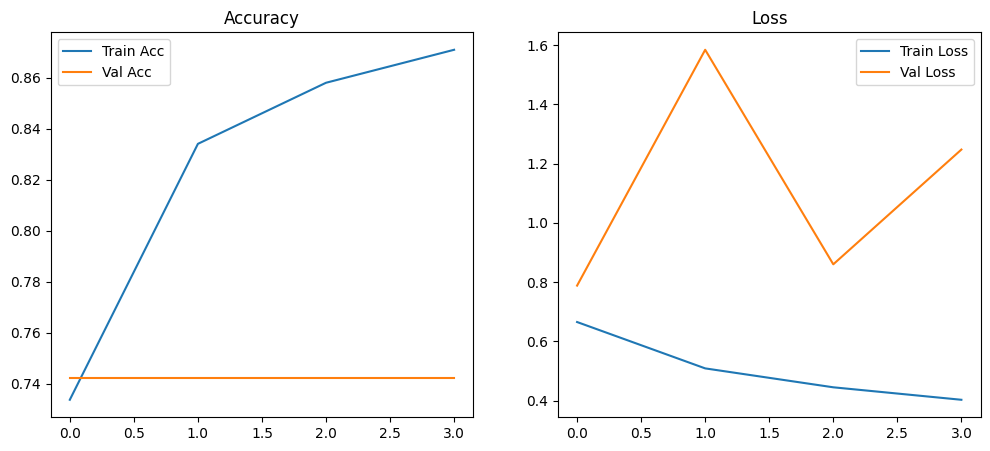

In [52]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend(); plt.title('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend(); plt.title('Loss')
    plt.show()

plot_history(history)


In [53]:
def plot_history(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Training vs Validation Performance')
    plt.show()


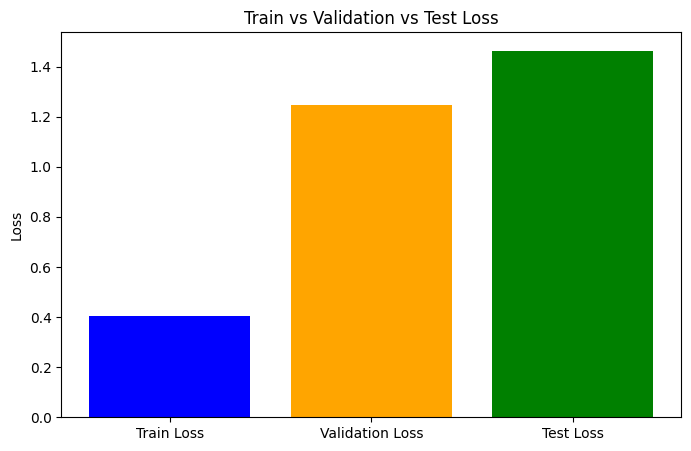

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(['Train Loss', 'Validation Loss', 'Test Loss'], [train_loss, val_loss, test_loss], color=['blue', 'orange', 'green'])
plt.title("Train vs Validation vs Test Loss")
plt.ylabel("Loss")
plt.show()


In [56]:
import numpy as np
from sklearn.metrics import confusion_matrix


y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs > 0.4).astype(int)


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:\n", cm)
print(f"False Negatives (Pneumonia predicted as Normal): {fn}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step
Confusion Matrix:
 [[  0 234]
 [  0 390]]
False Negatives (Pneumonia predicted as Normal): 0


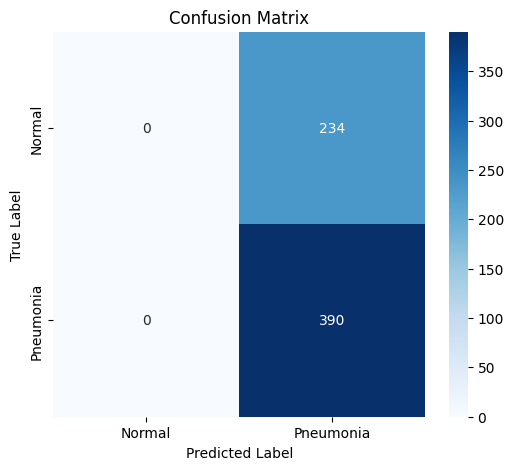

In [57]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [58]:
from tensorflow.keras.models import load_model

model.save('best_model.keras')

